# Python для анализа данных

## Как обработать датасет: стратегии работы с пропущенными, неинформативными и несогласованными данными. Основы работы с сайтом соревнований по машинному обучению kaggle.

*Ян Пиле, НИУ ВШЭ*

Когда мы работали с датасетом о пассажирах Титаника, мы уже встретились с пропущенными значениями в некоторых колонках. Теперь мы попробуем поамотреть на похожую ситуацию, но уже с другими данными. Сначала дадим "Определение".

Очистка данных – это процесс обнаружения и исправления (или удаления) поврежденных или неточных записей из набора записей, таблицы или базы данных. Процесс включает в себя выявление неполных, неправильных, неточных или несущественных данных, а затем замену, изменение или удаление «загрязненных» данных.

Звучит так себе. По порядку пройдемся по кусочкам этого определения и разберем методы поиска и исправления:

* отсутствующих данных;
* нетипичных данных – выбросов;
* неинформативных данных – дубликатов;
* несогласованных данных – одних и тех же данных, представленных в разных регистрах или форматах.

In [16]:
# импорт пакетов
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (24,16)
v = None

Для начала посмотрим , где лежат наши данные (заодно и познакомимся с kaggle):

https://www.kaggle.com/c/sberbank-russian-housing-market/overview/description 

Это данные о стоимости жилья.

In [11]:
# чтение данных
df = pd.read_csv('sberbank.csv')
# shape and data types of the data
print(df.shape)
# print(df.dtypes)

(30471, 292)


In [12]:
# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
# print(numeric_cols)
# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
# print(non_numeric_cols)

Набор данных состоит из 30471 строки и 292 столбцов. Отделим яисловые и нечисловые колонки.

Теперь мы можем просмотреть, что же тут такого «грязного» и как это очистить.

## Отсутствующие данные

Работа с отсутствующими значениями – одна из самых сложных, но и самых распространенных проблем очистки. Многие ML-модели не предполагают пропусков.

### Метод 1 - Тепловая карта

Приведенная карта построена для первых 30 признаков набора. По горизонтальной оси расположены признаки, по вертикальной – номера записей/строк. Желтый цвет соответствует пропускам данных.

Заметно, например, что признак life_sq имеет довольно много пустых строк, а признак floor – напротив, всего парочку – около 7000 строки.

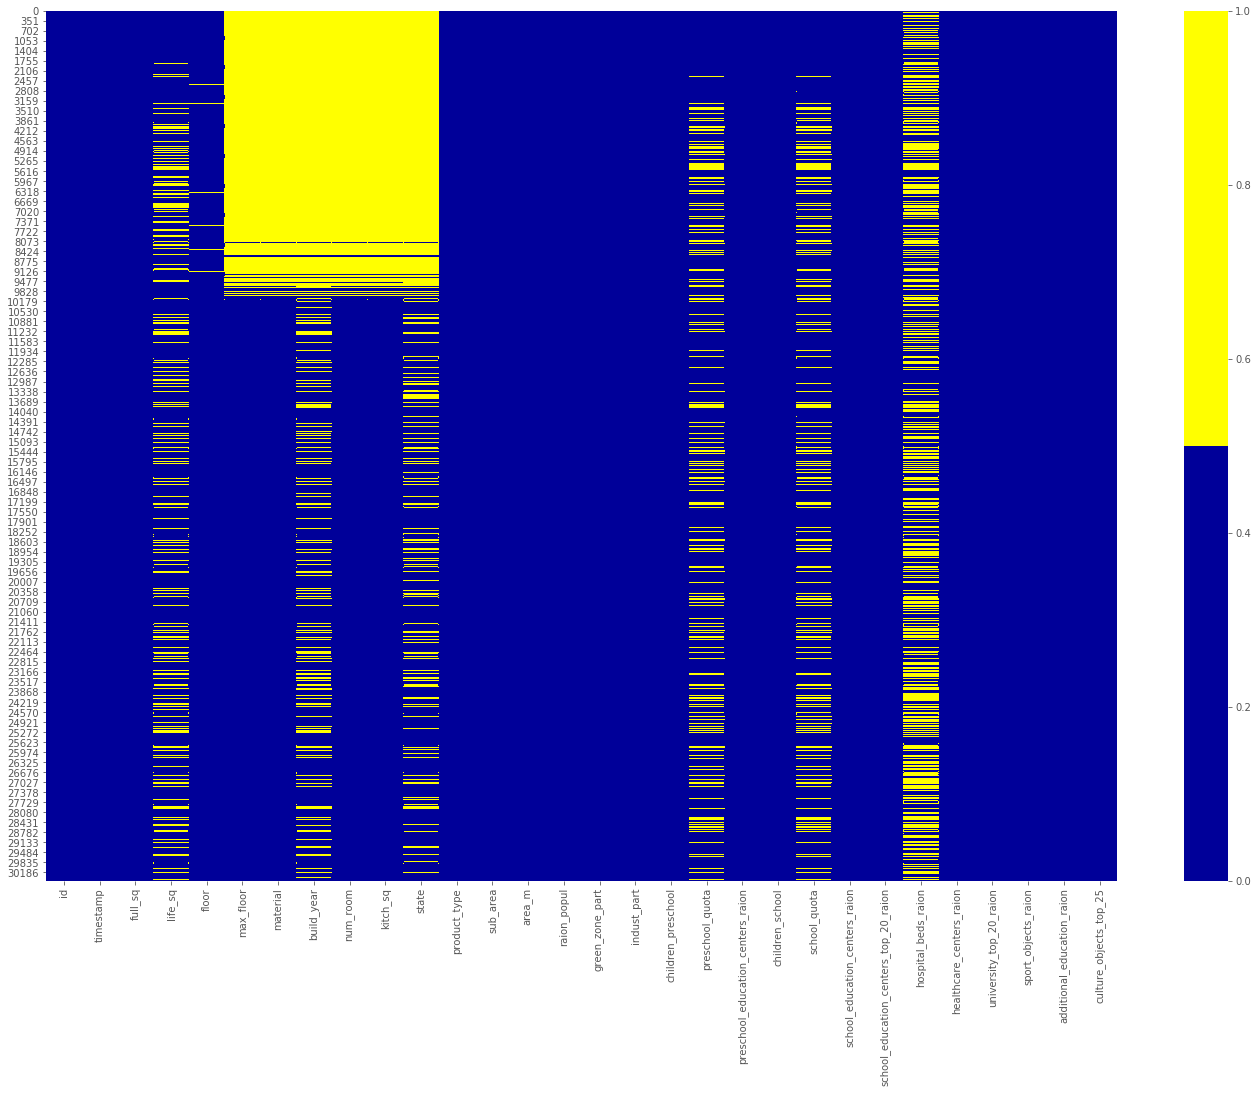

In [17]:
cols = df.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colors = ['#000099', '#ffff00'] 
a = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

## Метод 2 - Процентный список пропущенных данных
Если в наборе много признаков и визуализация занимает много времени, можно составить список долей отсутствующих записей для каждого признака. Скажем, картинка для всех признаков датасета будет выглядеть чудовищно.

In [23]:
for i, col in enumerate(df.columns):
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
    if i>=10:
        break

id - 0.0%
timestamp - 0.0%
full_sq - 0.0%
life_sq - 21.0%
floor - 1.0%
max_floor - 31.0%
material - 31.0%
build_year - 45.0%
num_room - 31.0%
kitch_sq - 31.0%
state - 44.0%


У признака life_sq отсутствует 21% значений, а у floor – только 1%.

Этот список является полезным резюме, которое дополняет визуализацию тепловой карты. На практике часто проще применить именно такое описание. 

## Метод 3 - Гистограмма пропущенных данных
Еще одна хорошая техника визуализации для наборов с большим количеством признаков – построение гистограммы для числа отсутствующих значений в записи.

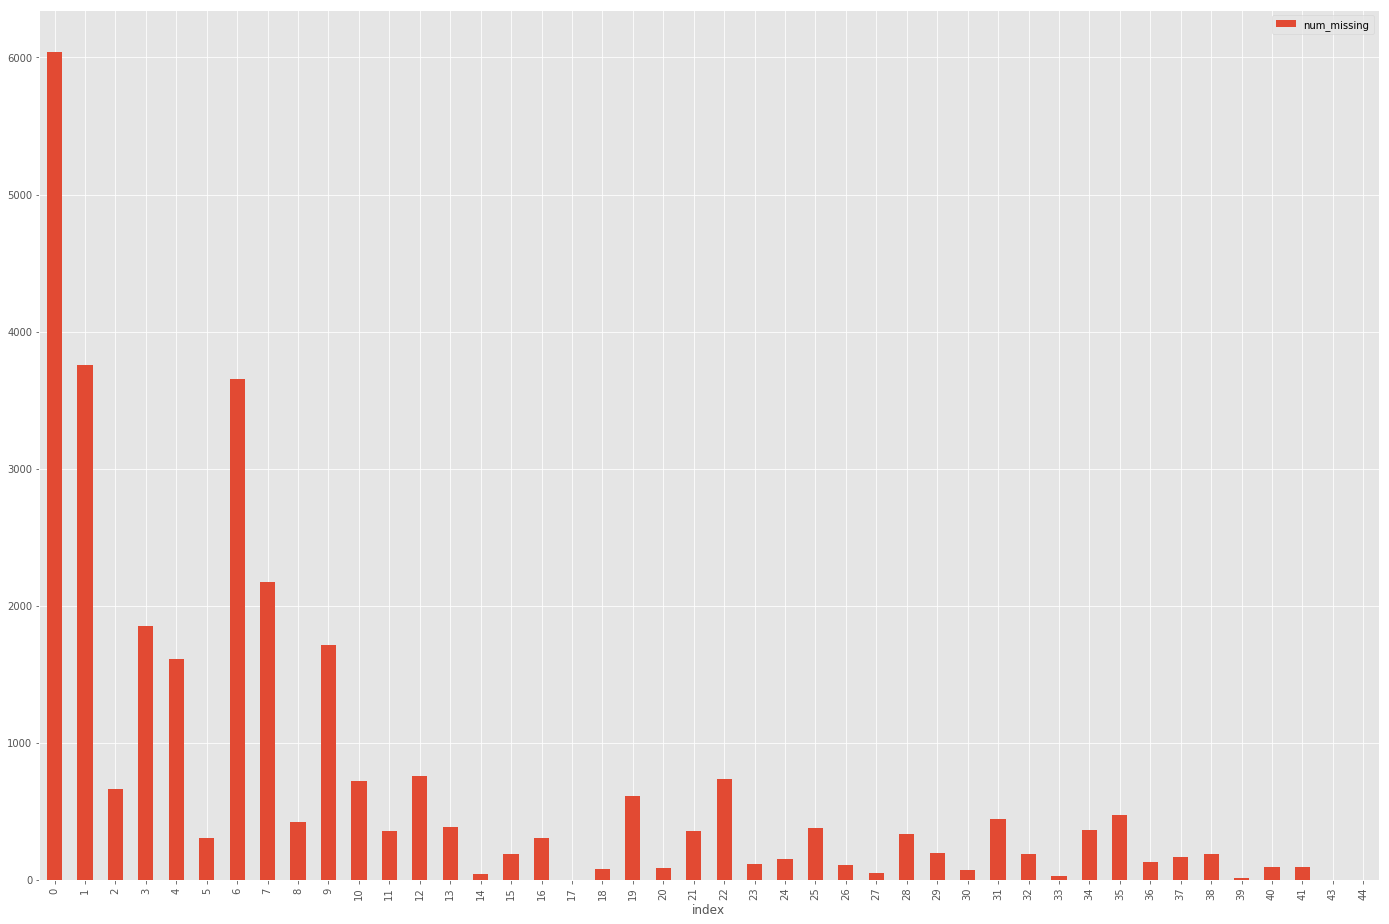

In [29]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)
u = df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index')

## Что делать с пропущенными значениями?
Не существует общих решений для проблемы отсутствующих данных. Для каждого конкретного набора приходится искать наиболее подходящие методы или их комбинации.

Разберем четыре самых распространенных техники. Они помогут в простых ситуациях, но, скорее всего, придется проявить творческий подход и поискать нетривиальные решения, например, промоделировать пропуски.

### Отбрасывание записей
Выбросим все строки с пропущенными значениями. Это решение подходит только в том случае, если недостающие данные не являются информативными.

Для отбрасывания можно использовать и другие критерии. Например, из гистограммы, построенной в предыдущем разделе, мы узнали, что лишь небольшое количество строк содержат более 35 пропусков. Мы можем создать новый набор данных df_less_missing_rows, в котором отбросим эти строки.

In [30]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df[df['num_missing'] > 35].index
df_less_missing_rows = df.drop(ind_missing, axis=0)

### Отбрасывание признаков

Как и предыдущая техника, отбрасывание признаков может применяться только для неинформативных признаков.

В процентном списке, построенном ранее, мы увидели, что признак hospital_beds_raion имеет высокий процент недостающих значений – 47%. Иногда от таких признаков можно отказаться совсем.

In [31]:
cols_to_drop = ['hospital_beds_raion']
df_less_hos_beds_raion = df.drop(cols_to_drop, axis=1)

### Внесение недостающих значений
Для численных признаков можно воспользоваться методом принудительного заполнения пропусков. Например, на место пропуска можно записать среднее, наиболее частое или медианное значение, полученное из остальных записей.

Для категориальных признаков можно использовать в качестве заполнителя наиболее часто встречающееся значение.

Возьмем для примера признак life_sq и заменим все недостающие значения медианой этого признака:

In [32]:
med = df['life_sq'].median()
print(med)
df['life_sq'] = df['life_sq'].fillna(med)

30.0


Одну и ту же стратегию заполнения можно применить сразу для всех числовых признаков:

In [34]:
# impute the missing values and create the missing value indicator variables for each numeric column.
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
#         print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        med = df[col].median()
        df[col] = df[col].fillna(med)

К счастью, в нашем наборе не нашлось пропусков в категориальных признаках. Но это не мешает нам продемонстрировать использование той же стратегии:

In [35]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
        top = df[col].describe()['top'] # impute with the most frequent value.
        df[col] = df[col].fillna(top)

### Метод 4 - Замена недостающих значений
Можно использовать некоторый дефолтный плейсхолдер для пропусков, например, новую категорию _MISSING_ для категориальных признаков или число -999 для числовых.

Таким образом, мы сохраняем данные о пропущенных значениях, что тоже может быть ценной информацией.

In [36]:
# категориальные признаки
df['sub_area'] = df['sub_area'].fillna('_MISSING_')
# численные признаки
df['life_sq'] = df['life_sq'].fillna(-999)

### А еще все эти методы уже сделали за нас

In [61]:
df = pd.read_csv('sberbank.csv')
test1 = df[cols].copy()
test1.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,10309,11065.0,5,0,240.0,1,0,7,3,no
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,7759,6237.0,8,0,229.0,1,0,6,1,yes
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,6207,5580.0,7,0,1183.0,1,0,5,1,no
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,13670,17063.0,10,0,NaN,1,0,17,6,no
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,6748,7770.0,9,0,562.0,4,2,25,2,no


In [62]:
from sklearn.impute import SimpleImputer
imp_mf = SimpleImputer( strategy='most_frequent')
imp_mf.fit(test1)
imputed_test1_df = imp_mf.transform(test1)
pd.DataFrame(imputed_test1_df, columns = cols).head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25
0,1,2011-08-20,43,27,4,17,1,2014,2,1,...,10309,11065,5,0,240,1,0,7,3,no
1,2,2011-08-23,34,19,3,17,1,2014,2,1,...,7759,6237,8,0,229,1,0,6,1,yes
2,3,2011-08-27,43,29,2,17,1,2014,2,1,...,6207,5580,7,0,1183,1,0,5,1,no
3,4,2011-09-01,89,50,9,17,1,2014,2,1,...,13670,17063,10,0,540,1,0,17,6,no
4,5,2011-09-05,77,77,4,17,1,2014,2,1,...,6748,7770,9,0,562,4,2,25,2,no


In [64]:
df = pd.read_csv('sberbank.csv')
test1 = df[cols[3:10]].copy()
imp_mean = SimpleImputer( strategy='mean')
imp_mean.fit(test1)
imputed_test1_df = imp_mean.transform(test1)
pd.DataFrame(imputed_test1_df, columns = list(cols[3:10])).head()

,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq
0,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301
1,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301
2,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301
3,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301
4,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301


А еще можно подробненько прочесть вот тут:

https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

## Нетипичные данные (выбросы)
Выбросы – это данные, которые существенно отличаются от других наблюдений. Они могут соответствовать реальным отклонениям, но могут быть и просто ошибками.

### Как обнаружить выбросы?

Для численных и категориальных признаков используются разные методы изучения распределения, позволяющие обнаружить выбросы.

### Гистограмма
Если признак численный, можно построить гистограмму или коробчатую диаграмму (ящик с усами). Посмотрим на примере уже знакомого нам признака life_sq.

In [69]:
matplotlib.rcParams['figure.figsize'] = (12,8)

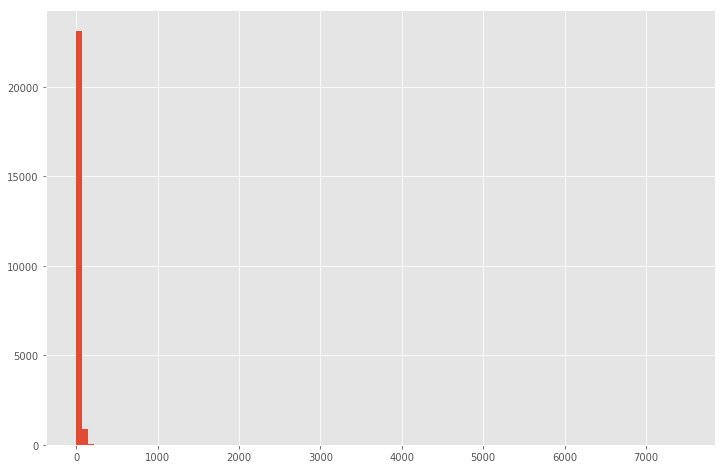

In [70]:
a = df['life_sq'].hist(bins=100)

Чтобы изучить особенность поближе, построим коробчатую диаграмму (aka ящик с усами)

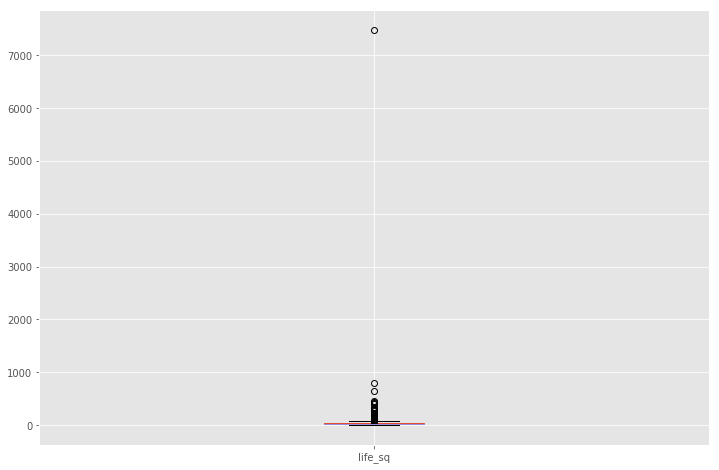

In [71]:
df.boxplot(column=['life_sq'])

### Столбчатая диаграмма
Для категориальных признаков можно построить столбчатую диаграмму – для визуализации данных о категориях и их распределении.

Например, распределение признака ecology вполне равномерно и допустимо. Но если существует категория только с одним значением "другое", то это будет выброс.

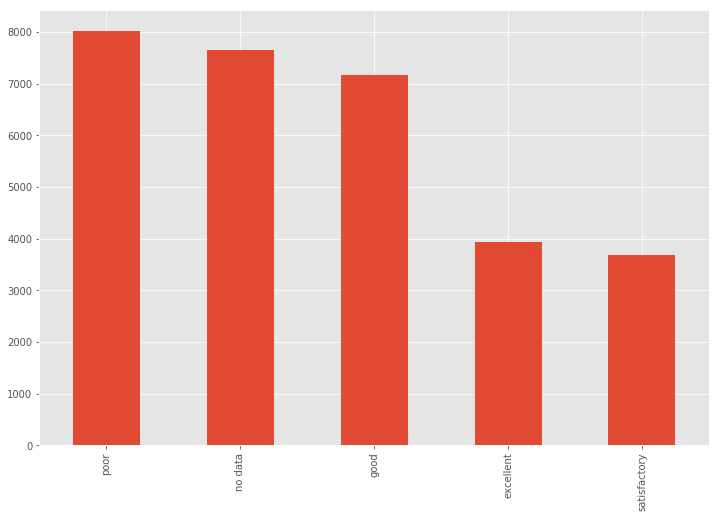

In [72]:
a = df['ecology'].value_counts().plot.bar()

А еще есть огромное количество более умных методов обнаружения выбросов!
Особым любителям математики читать тут: https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

Выбросы довольно просто обнаружить, но выбор способа их устранения слишком существенно зависит от специфики набора данных и целей проекта. Их обработка во многом похожа на обработку пропущенных данных, которую мы разбирали в предыдущем разделе. Можно удалить записи или признаки с выбросами, либо скорректировать их, либо оставить без изменений.

Переходим к более простой части очистки данных – удалению мусора.

Вся информация, поступающая в модель, должна служить целям проекта. Если она не добавляет никакой ценности, от нее следует избавиться.

Три основных типа «ненужных» данных:

* неинформативные признаки с большим количеством одинаковых значений,
* нерелевантные признаки,
* дубликаты записей.

## Неинформативные признаки

Если признак имеет слишком много строк с одинаковыми значениями, он не несет полезной информации для проекта. Составим список признаков, у которых более 95% строк содержат одно и то же значение.

In [73]:
num_rows = len(df.index)
low_information_cols = [] #
for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.02858%
no     30175
yes      296
Name: oil_chemistry_raion, dtype: int64
()
railroad_terminal_raion: 96.27187%
no     29335
yes     1136
Name: railroad_terminal_raion, dtype: int64
()
nuclear_reactor_raion: 97.16780%
no     29608
yes      863
Name: nuclear_reactor_raion, dtype: int64
()
big_road1_1line: 97.43691%
no     29690
yes      781
Name: big_road1_1line, dtype: int64
()
railroad_1line: 97.06934%
no     29578
yes      893
Name: railroad_1line, dtype: int64
()
cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64
()
mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64
()
cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64
()
mosque_count_1000: 98.08342%
0    29887
1      584
Name: mosque_count_1000, dtype: int64
()
mosque_count_1500:

### Что делать?
Если после анализа причин получения повторяющихся значений вы пришли к выводу, что признак не несет полезной информации, используйте drop().

## Нерелевантные признаки

Нерелевантные признаки обнаруживаются ручным отбором и оценкой значимости. Например, признак, регистрирующий температуру воздуха в Торонто точно не имеет никакого отношения к прогнозированию цен на российское жилье. Если признак не имеет значения для проекта, его нужно исключить. Но этот вопрос надо обсудить отдельно: иногда можно выявить эффект "ложной корреляции" и счесть важным в действительности неважный признак.

## Дубликаты записей
Если значения признаков (всех или большинства) в двух разных записях совпадают, эти записи называются дубликатами.

###  Как обнаружить повторяющиеся записи?
Способ обнаружения дубликатов зависит от того, что именно мы считаем дубликатами. Например, в наборе данных есть уникальный идентификатор id. Если две записи имеют одинаковый id, мы считаем, что это одна и та же запись. Удалим все неуникальные записи:

In [74]:
# отбрасываем неуникальные строки
df_dedupped = df.drop('id', axis=1).drop_duplicates()
# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)

(30471, 292)
(30461, 291)


Получаем в результате 10 отброшенных дубликатов.

Другой распространенный способ вычисления дубликатов: по набору ключевых признаков. Например, неуникальными можно считать записи с одной и той же площадью жилья, ценой и годом постройки.

Найдем в нашем наборе дубликаты по группе критических признаков – **full_sq, life_sq, floor, build_year, num_room, price_doc:**

In [75]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year', 'num_room', 'price_doc']
df.fillna(-999).groupby(key)['id'].count().sort_values(ascending=False).head(20)

timestamp   full_sq  life_sq  floor  build_year  num_room  price_doc
2014-12-09  40       -999.0   17.0   -999.0       1.0      4607265      2
2014-04-15  134       134.0   1.0     0.0         3.0      5798496      2
2013-08-30  40       -999.0   12.0   -999.0       1.0      4462000      2
2012-09-05  43       -999.0   21.0   -999.0      -999.0    6229540      2
2013-12-05  40       -999.0   5.0    -999.0       1.0      4414080      2
2014-12-17  62       -999.0   9.0    -999.0       2.0      6552000      2
2013-05-22  68       -999.0   2.0    -999.0      -999.0    5406690      2
2012-08-27  59       -999.0   6.0    -999.0      -999.0    4506800      2
2013-04-03  42       -999.0   2.0    -999.0      -999.0    3444000      2
2015-03-14  62       -999.0   2.0    -999.0       2.0      6520500      2
2014-01-22  46        28.0    1.0     1968.0      2.0      3000000      2
2012-10-22  61       -999.0   18.0   -999.0      -999.0    8248500      2
2013-09-23  85       -999.0   14.0   -999.0

Получили в результате 16 дублирующихся записей.

## Что делать с дубликатами?
Очевидно, что повторяющиеся записи нам не нужны, значит, их нужно исключить из набора.

Вот так выглядит удаление дубликатов, основанное на наборе ключевых признаков:

In [76]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year', 'num_room', 'price_doc']
df_dedupped2 = df.drop_duplicates(subset=key)
print(df.shape)
print(df_dedupped2.shape)

(30471, 292)
(30455, 292)


Новый набор df_dedupped2 стал короче на 16 записей.

Большая проблема очистки данных – разные форматы записей. Для корректной работы модели важно, чтобы набор данных соответствовал определенным стандартам – необходимо тщательное исследование с учетом специфики самих данных. Мы рассмотрим четыре самых распространенных несогласованности:

* Разные регистры символов.
* Разные форматы данных (например, даты).
* Опечатки в значениях категориальных признаков.
* Адреса.

## Разные регистры символов
Непоследовательное использование разных регистров в категориальных значениях является очень распространенной ошибкой, которая может существенно повлиять на анализ данных.

### Как обнаружить?
Давайте посмотрим на признак sub_area:

In [78]:
df['sub_area'].value_counts(dropna=False)[:10]

Poselenie Sosenskoe         1776
Nekrasovka                  1611
Poselenie Vnukovskoe        1372
Poselenie Moskovskij         925
Poselenie Voskresenskoe      713
Mitino                       679
Tverskoe                     678
Krjukovo                     518
Mar'ino                      508
Poselenie Filimonkovskoe     496
Name: sub_area, dtype: int64

Но если в какой-то записи вместо Poselenie Sosenskoe окажется poselenie sosenskoe, они будут расценены как два разных значения.

### Что делать?
Проблема легко решается принудительным изменением регистра:

In [80]:
# пусть все будет в нижнем регистре
df['sub_area_lower'] = df['sub_area'].str.lower()
df['sub_area_lower'].value_counts(dropna=False)[:10]

poselenie sosenskoe         1776
nekrasovka                  1611
poselenie vnukovskoe        1372
poselenie moskovskij         925
poselenie voskresenskoe      713
mitino                       679
tverskoe                     678
krjukovo                     518
mar'ino                      508
poselenie filimonkovskoe     496
Name: sub_area_lower, dtype: int64

## Разные форматы данных
Ряд данных в наборе находится не в том формате, с которым нам было бы удобно работать. Например, даты, записанные в виде строки, следует преобразовать в формат DateTime. Признак timestamp представляет собой строку, хотя является датой:

### Что же делать?
Чтобы было проще анализировать транзакции по годам и месяцам, значения признака timestamp следует преобразовать в удобный формат:

In [81]:
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df['year'] = df['timestamp_dt'].dt.year
df['month'] = df['timestamp_dt'].dt.month
df['weekday'] = df['timestamp_dt'].dt.weekday
print(df['year'].value_counts(dropna=False))
print()
print(df['month'].value_counts(dropna=False))

2014    13662
2013     7978
2012     4839
2015     3239
2011      753
Name: year, dtype: int64
()
12    3400
4     3191
3     2972
11    2970
10    2736
6     2570
5     2496
9     2346
2     2275
7     1875
8     1831
1     1809
Name: month, dtype: int64


Ссылочка для тех, кто хочет крутить даты в Python как жонглер из Cirque Du Soleil:

https://towardsdatascience.com/how-to-manipulate-date-and-time-in-python-like-a-boss-ddea677c6a4d

## Опечатки
Опечатки в значениях категориальных признаков приводят к таким же проблемам, как и разные регистры символов.

### Как обнаружить?

Для обнаружения опечаток требуется особый подход. В нашем наборе данных о недвижимости опечаток нет, поэтому для примера создадим новый набор. В нем будет признак city, а его значениями будут torontoo и tronto. В обоих случаях это опечатки, а правильное значение – toronto.

Простой способ идентификации подобных элементов – [расстояние Левенштейна](https://ru.wikipedia.org/wiki/Расстояние_Левенштейна). Суть этого метода заключается в измерении количества букв (расстояния), которые нам нужно изменить, чтобы из одного слова получить другое.

Предположим, нам известно, что в признаке city должно находиться одно из четырех значений: toronto, vancouver, montreal или calgary. Мы вычисляем расстояние между всеми значениями и словом toronto (и vancouver).

Те слова, в которых содержатся опечатки, имеют меньшее расстояние с правильным словом, так как отличаются всего на пару букв.

In [82]:
from nltk.metrics import edit_distance
df_city_ex = pd.DataFrame(data={'city': ['torontoo', 'toronto', 'tronto', 'vancouver', 'vancover', 'vancouvr', 'montreal', 'calgary']})
df_city_ex['city_distance_toronto'] = df_city_ex['city'].map(lambda x: edit_distance(x, 'toronto'))
df_city_ex['city_distance_vancouver'] = df_city_ex['city'].map(lambda x: edit_distance(x, 'vancouver'))
df_city_ex

,city,city_distance_toronto,city_distance_vancouver
0,torontoo,1,8
1,toronto,0,8
2,tronto,1,8
3,vancouver,8,0
4,vancover,7,1
5,vancouvr,7,1
6,montreal,7,8
7,calgary,7,8


Мы можем установить критерии для преобразования этих опечаток в правильные значения.

Например, если расстояние некоторого значения от слова toronto не превышает 2 буквы, мы преобразуем это значение в правильное – toronto.

In [83]:
msk = df_city_ex['city_distance_toronto'] <= 2
df_city_ex.loc[msk, 'city'] = 'toronto'
msk = df_city_ex['city_distance_vancouver'] <= 2
df_city_ex.loc[msk, 'city'] = 'vancouver'
df_city_ex

,city,city_distance_toronto,city_distance_vancouver
0,toronto,1,8
1,toronto,0,8
2,toronto,1,8
3,vancouver,8,0
4,vancouver,7,1
5,vancouver,7,1
6,montreal,7,8
7,calgary,7,8


## Оставим главную боль напоследок

Проще предположить, что проблема разных форматов адреса точно существует. Даже если визуально вы не обнаружили беспорядка в этом признаке, все равно стоит стандартизировать их для надежности.

В нашем наборе данных по соображениям конфиденциальности отсутствует признак адреса, поэтому создадим новый набор df_add_ex:

In [84]:
df_add_ex = pd.DataFrame(['123 MAIN St Apartment 15', '123 Main Street Apt 12   ', '543 FirSt Av', '  876 FIRst Ave.'], columns=['address'])
df_add_ex

,address
0,123 MAIN St Apartment 15
1,123 Main Street Apt 12
2,543 FirSt Av
3,876 FIRst Ave.


### Что делать?

Минимальное форматирование включает следующие операции:

* приведение всех символов к нижнему регистру;
* удаление пробелов в начале и конце строки;
* удаление точек;
* стандартизация формулировок: замена street на st, apartment на apt и т. д.

In [85]:
df_add_ex['address_std'] = df_add_ex['address'].str.lower()
df_add_ex['address_std'] = df_add_ex['address_std'].str.strip()
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\.', '') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bstreet\\b', 'st') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bapartment\\b', 'apt') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bav\\b', 'ave') 
df_add_ex

,address,address_std
0,123 MAIN St Apartment 15,123 main st apt 15
1,123 Main Street Apt 12,123 main st apt 12
2,543 FirSt Av,543 first ave
3,876 FIRst Ave.,876 first ave


А еще это идеальный момент для применения регулярных выражений :)